# Baseline Model Preprocessing

In [2]:
import pandas as pd

In [18]:
baseline_df = pd.read_hdf(r"C:\Users\Linds\Repos\East_River\data\east_river_dataset-v1.h5")

Validate target column

In [19]:
baseline_df[['OnLine_Load_MW', 'Load_Control_MW', 'Estimated_Online_Load_Control_MW']].head(500)

,OnLine_Load_MW,Load_Control_MW,Estimated_Online_Load_Control_MW
0,0.00,5.077996,500.291922
225,0.00,5.077996,500.291922
441,0.00,5.077996,500.291922
660,0.00,5.077996,500.291922
763,0.00,5.077996,500.291922
...,...,...,...
86275,487.78,0.728000,488.508000
86418,487.32,0.728000,488.048000
86616,485.52,0.728000,486.248000
86772,484.41,0.728000,485.138000


We've already converted this feature to MW and are predicting in MW. We will drop for now.

In [20]:
baseline_df = baseline_df.drop(columns=["Load_Control_KW"])

In [21]:
# Validate the target column: 'OnLine_Load_MW'
print("Summary statistics for 'OnLine_Load_MW':")
print(baseline_df['OnLine_Load_MW'].describe())

missing_values = baseline_df['OnLine_Load_MW'].isnull().sum()
print("\nMissing values in 'OnLine_Load_MW':", missing_values)

Summary statistics for 'OnLine_Load_MW':
count    1.216869e+07
mean     4.949024e+02
std      8.103625e+01
min      0.000000e+00
25%      4.352100e+02
50%      4.923700e+02
75%      5.511300e+02
max      8.552600e+02
Name: OnLine_Load_MW, dtype: float64

Missing values in 'OnLine_Load_MW': 0


IQR method - Lower bound: 261.3299999999999 Upper bound: 725.01
Number of outliers: 66990


c:\Users\Linds\anaconda3\envs\load_forecasting_env\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


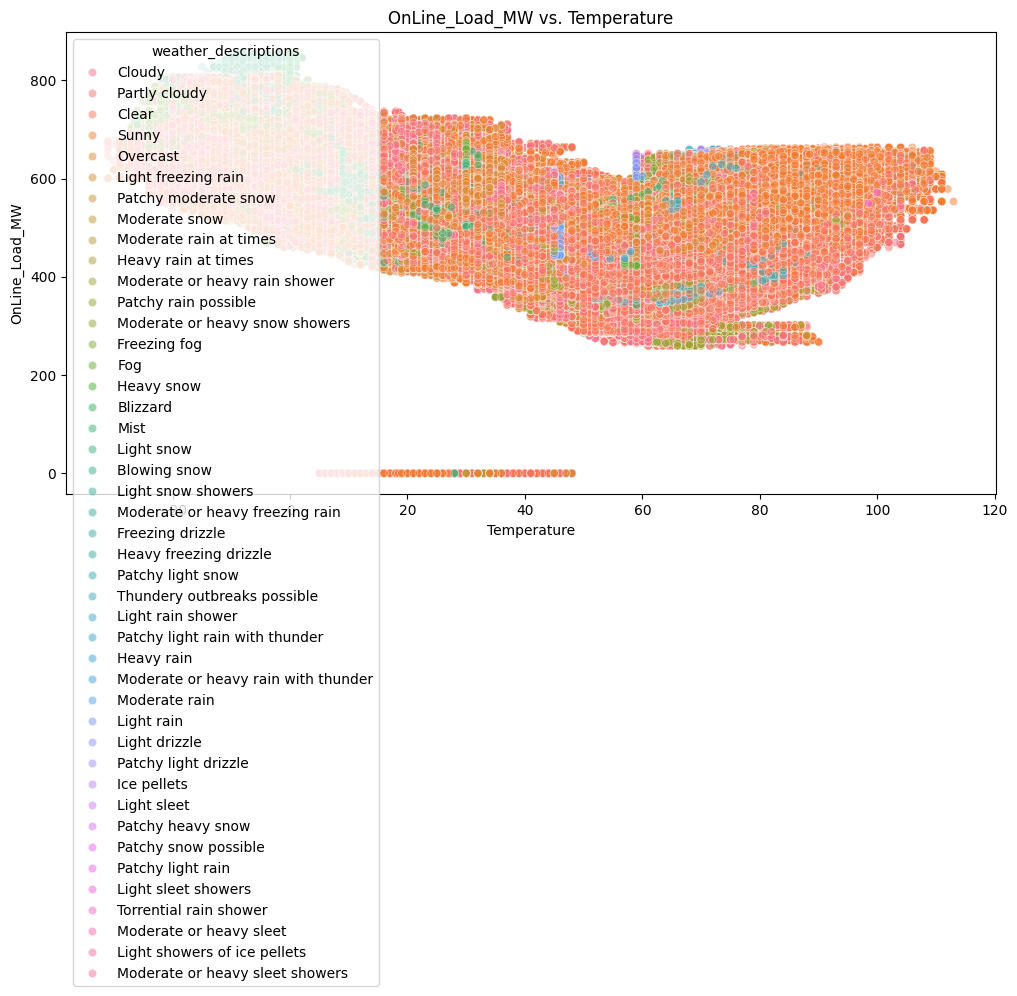

c:\Users\Linds\anaconda3\envs\load_forecasting_env\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


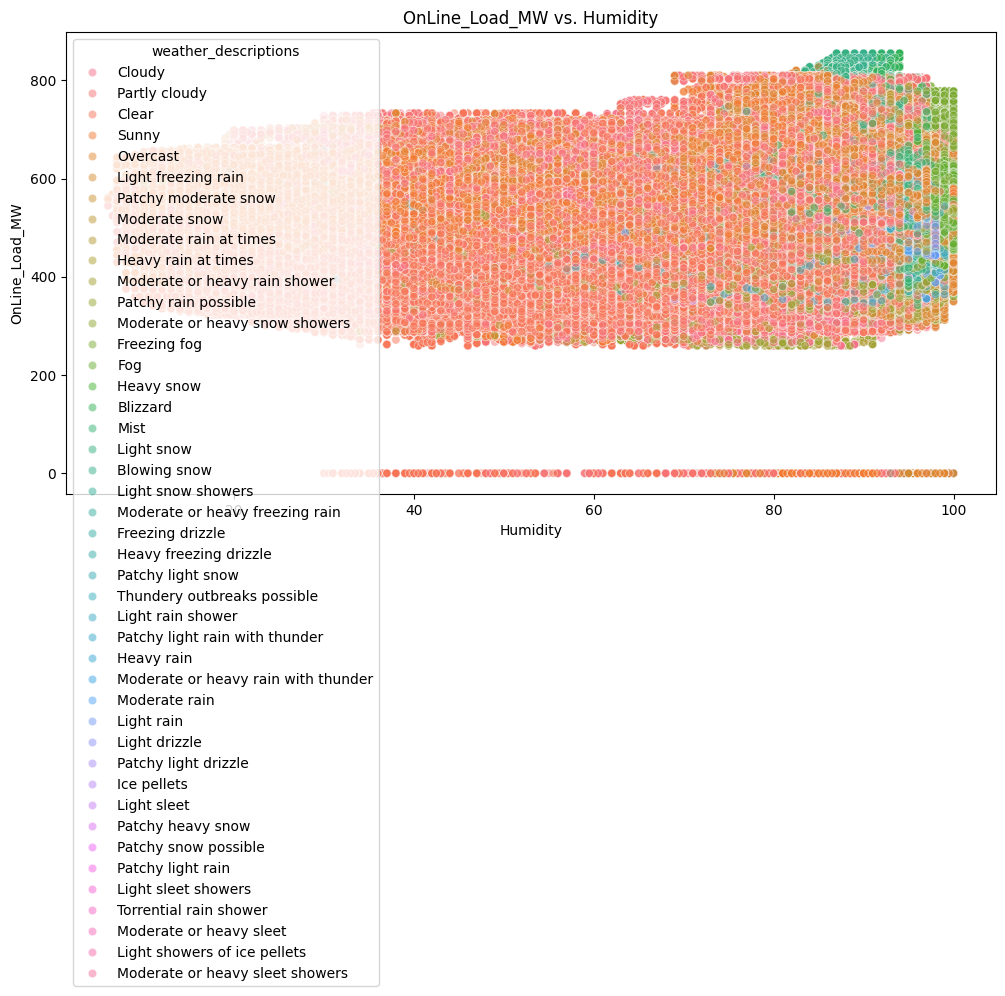

c:\Users\Linds\anaconda3\envs\load_forecasting_env\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


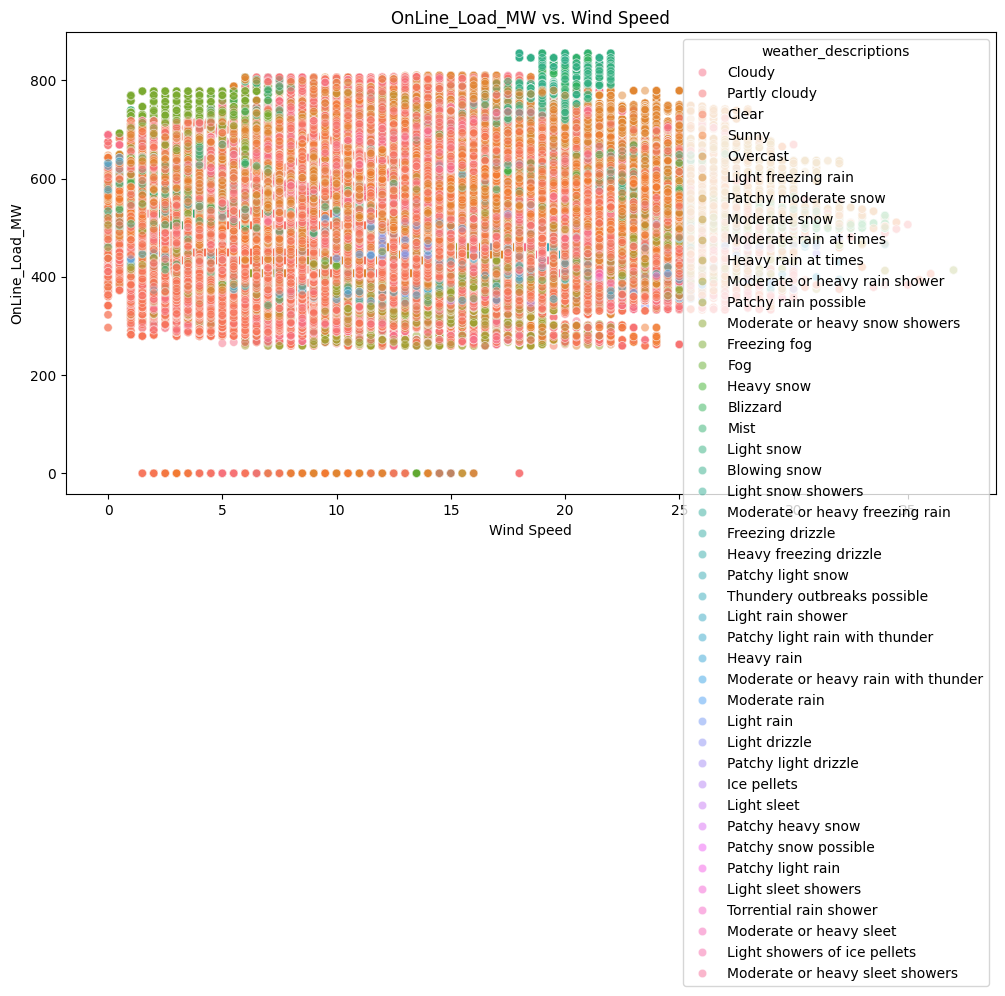

In [8]:
import seaborn as sns

# We'll first identify potential outliers in the target variable 'OnLine_Load_MW'
Q1 = baseline_df['OnLine_Load_MW'].quantile(0.25)
Q3 = baseline_df['OnLine_Load_MW'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print("IQR method - Lower bound:", lower_bound, "Upper bound:", upper_bound)

outliers = baseline_df[(baseline_df['OnLine_Load_MW'] < lower_bound) | 
                       (baseline_df['OnLine_Load_MW'] > upper_bound)]
print("Number of outliers:", outliers.shape[0])

# Next, let's plot the load vs. some weather features to help compare
import matplotlib.pyplot as plt

# Plot load vs. temperature
plt.figure(figsize=(12, 6))
sns.scatterplot(data=baseline_df, x='temperature', y='OnLine_Load_MW', hue='weather_descriptions', alpha=0.5)
plt.title("OnLine_Load_MW vs. Temperature")
plt.xlabel("Temperature")
plt.ylabel("OnLine_Load_MW")
plt.show()

# Plot load vs. humidity
plt.figure(figsize=(12, 6))
sns.scatterplot(data=baseline_df, x='humidity', y='OnLine_Load_MW', hue='weather_descriptions', alpha=0.5)
plt.title("OnLine_Load_MW vs. Humidity")
plt.xlabel("Humidity")
plt.ylabel("OnLine_Load_MW")
plt.show()

# Plot load vs. wind speed
plt.figure(figsize=(12, 6))
sns.scatterplot(data=baseline_df, x='wind_speed', y='OnLine_Load_MW', hue='weather_descriptions', alpha=0.5)
plt.title("OnLine_Load_MW vs. Wind Speed")
plt.xlabel("Wind Speed")
plt.ylabel("OnLine_Load_MW")
plt.show()

most load values (OnLine_Load_MW) fall between about 261.33 MW and 725.01 MW—with Q1 at 435.21 MW and Q3 at 551.13 MW giving an IQR of 115.92. Values outside this range are flagged as outliers. The scatter plots show how load values change with weather conditions (temperature, humidity, and wind speed) and use weather descriptions to help spot any patterns that might explain the variability or the outliers.

- The target variable (OnLine_Load_MW) has an interquartile range (IQR) of about 115.92 MW.
- Values below approximately 261.33 MW or above 725.01 MW are considered outliers, which could affect modeling if not handled properly.
- Scatter plots against temperature, humidity, and wind speed—with points colored by weather description—help reveal how different weather conditions relate to load variability.
- These visualizations can guide further exploration into which weather features might most strongly influence load, aiding in feature selection for predictive modeling.
- Results confirm what East River knew about cold events on load, and logic suggests. A good sanity check for our dataset. 

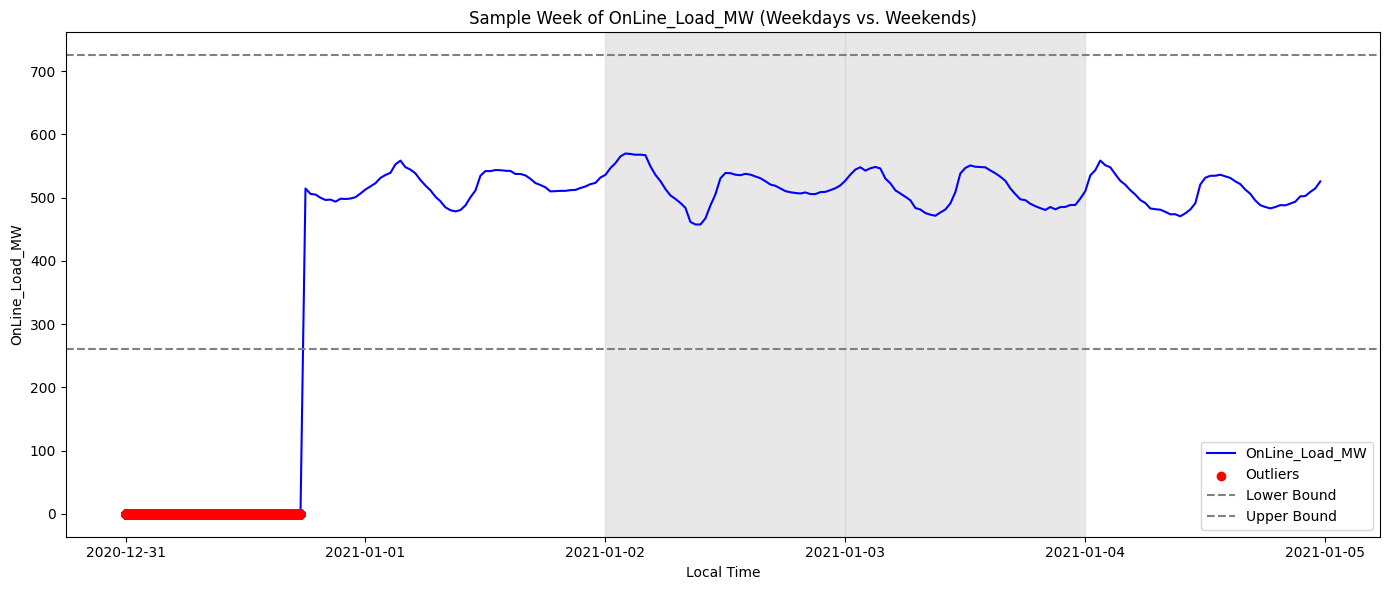

In [9]:
# Select a sample period (one week) using the local_time column
sample_start = pd.Timestamp('2020-12-29', tz='America/Chicago')
sample_end = pd.Timestamp('2021-01-05', tz='America/Chicago')
sample_df = baseline_df[(baseline_df['local_time'] >= sample_start) & (baseline_df['local_time'] < sample_end)].copy()

# Ensure the data is sorted by local_time
sample_df.sort_values('local_time', inplace=True)

# Get outliers within the sample period
sample_outliers = outliers[(outliers['local_time'] >= sample_start) & (outliers['local_time'] < sample_end)]

plt.figure(figsize=(14, 6))

# Plot the full time series of OnLine_Load_MW in the sample period
plt.plot(sample_df['local_time'], sample_df['OnLine_Load_MW'], label='OnLine_Load_MW', color='blue')

# Mark the outliers in red
plt.scatter(sample_outliers['local_time'], sample_outliers['OnLine_Load_MW'], color='red', label='Outliers', zorder=5)

# Add horizontal lines for the lower and upper expected bounds
plt.axhline(lower_bound, color='gray', linestyle='--', label='Lower Bound')
plt.axhline(upper_bound, color='gray', linestyle='--', label='Upper Bound')

# Shade weekends in the selected period to visually compare weekday vs. weekend load patterns
unique_dates = pd.date_range(start=sample_start.normalize(), end=sample_end.normalize(), freq='D')
for day in unique_dates:
    if day.weekday() >= 5:  # Saturday (5), Sunday (6)
        plt.axvspan(day, day + pd.Timedelta(days=1), color='lightgray', alpha=0.5)

plt.xlabel('Local Time')
plt.ylabel('OnLine_Load_MW')
plt.title('Sample Week of OnLine_Load_MW (Weekdays vs. Weekends)')
plt.legend()

plt.tight_layout()
plt.show()

# Note: After visually identifying suspicious intervals (e.g., atypical peaks or drops), 
# cross-reference these intervals with the 'weather_event' column or check for missing data in weather variables.

In [22]:
# Step 1: Handle missing values and remove duplicates
print("Missing values per column:")
print(baseline_df.isnull().sum())

baseline_df = baseline_df.drop_duplicates()
print("After dropping duplicates, dataset shape:", baseline_df.shape)


Missing values per column:
location                         0
datetime                         0
temperature                      0
wind_speed                       0
wind_degree                      0
                                ..
was_controlled                   0
load_lag_1_rolling_mean_6hrs     0
load_lag_1_rolling_std_6hrs      0
load_lag_1_rolling_mean_24hrs    0
load_lag_1_rolling_std_24hrs     0
Length: 85, dtype: int64
After dropping duplicates, dataset shape: (12168690, 85)


In [14]:
# Define a list of core numerical features that we want to keep
core_features = [
    'temperature', 'wind_speed', 'wind_degree', 'humidity', 'visibility', 'pressure',
    'cloudcover', 'heatindex', 'windchill', 'windgust', 'feelslike', 'uv_index',
    'snowfall', 'snow_depth', 'relative_humidity_2m', 'global_tilted_irradiance',
    'diffuse_radiation', 'direct_radiation', 'pressure_msl', 'surface_pressure',
    'blended_precip', 'latitude', 'longitude',
    'OnLine_Load_MW', 'Load_Control_MW', 'Estimated_Online_Load_Control_MW', 'Control_Threshold_MW'
]

# Retain only the core numerical features in baseline_df
baseline_df = baseline_df[core_features]

print("Reduced dataset shape:", baseline_df.shape)
baseline_df.head()

Reduced dataset shape: (12168690, 27)


,temperature,wind_speed,wind_degree,humidity,visibility,pressure,cloudcover,heatindex,windchill,windgust,...,direct_radiation,pressure_msl,surface_pressure,blended_precip,latitude,longitude,OnLine_Load_MW,Load_Control_MW,Estimated_Online_Load_Control_MW,Control_Threshold_MW
0,12.0,7.0,197.0,90.0,6.0,30.120,69.0,12.0,0.0,15.0,...,0.0,1016.50,945.10,0.0,43.971878,-99.969666,0.0,5.077996,500.291922,593.103098
225,11.0,7.0,196.0,90.0,6.0,30.105,61.0,11.0,0.0,15.5,...,0.0,1016.25,944.80,0.0,43.971878,-99.969666,0.0,5.077996,500.291922,593.103098
441,10.0,7.0,195.0,90.0,6.0,30.090,53.0,10.0,0.0,16.0,...,0.0,1016.00,944.50,0.0,43.971878,-99.969666,0.0,5.077996,500.291922,593.103098
660,10.0,7.0,194.0,89.5,6.0,30.090,45.5,10.0,0.0,16.0,...,0.0,1016.25,944.55,0.0,43.971878,-99.969666,0.0,5.077996,500.291922,593.103098
763,10.0,7.0,193.0,89.0,6.0,30.090,38.0,10.0,0.0,16.0,...,0.0,1016.50,944.60,0.0,43.971878,-99.969666,0.0,5.077996,500.291922,593.103098


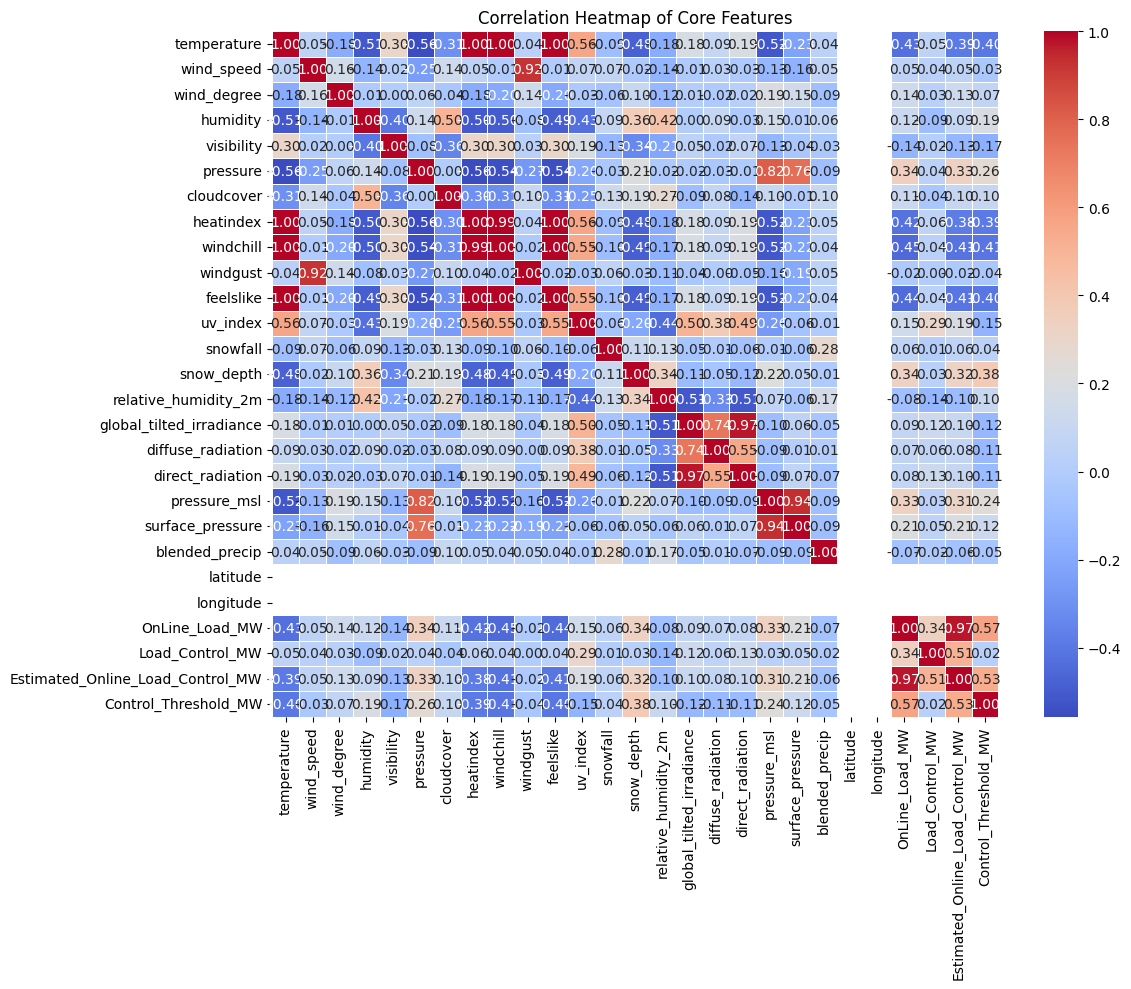

In [15]:
# Compute correlation matrix for numeric columns in baseline_df (core features)
corr_matrix = baseline_df.select_dtypes(include='number').corr()

# Plot the correlation heatmap using only core features
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap of Core Features")
plt.tight_layout()
plt.show()

In [23]:
import numpy as np

# Compute the absolute correlation matrix of numerical features
corr_matrix = baseline_df.select_dtypes(include='number').corr().abs()

# Create a mask for the upper triangle
mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)

# Select features having a correlation above the defined threshold
threshold = 0.95
to_drop = [column for column in corr_matrix.columns if (corr_matrix.where(mask)[column] > threshold).any()]

print("Features to drop due to high correlation:", to_drop)

# Drop the highly correlated features from the dataset
baseline_df = baseline_df.drop(columns=to_drop)
print("Reduced dataset shape after dropping highly correlated features:", baseline_df.shape)

Features to drop due to high correlation: ['heatindex', 'windchill', 'feelslike', 'direct_radiation', 'Estimated_Online_Load_Control_MW', 'minutes_since_midnight', 'load_lag_1', 'load_lag_2', 'load_lag_3', 'load_lag_3_rolling_mean_3', 'load_lag_3_rolling_mean_6', 'load_lag_3_rolling_mean_12', 'load_lag_3_rolling_mean_6hrs', 'load_lag_3_rolling_std_6hrs', 'load_lag_3_rolling_mean_24hrs', 'precip_sum_12hrs', 'precip_sum_24hrs', 'heatindex_mean_6hrs', 'heatindex_mean_12hrs', 'heatindex_mean_24hrs', 'day_of_year', 'iso_week', 'load_lag_1_rolling_mean_24hrs']
Reduced dataset shape after dropping highly correlated features: (12168690, 62)


In [24]:
print("Remaining features in baseline_df:")
print(baseline_df.columns.tolist())

Remaining features in baseline_df:
['location', 'datetime', 'temperature', 'wind_speed', 'wind_degree', 'humidity', 'visibility', 'pressure', 'cloudcover', 'windgust', 'uv_index', 'wind_dir', 'weather_descriptions', 'snowfall', 'snow_depth', 'relative_humidity_2m', 'global_tilted_irradiance', 'diffuse_radiation', 'pressure_msl', 'surface_pressure', 'blended_precip', 'latitude', 'longitude', 'noaa_station_name', 'OnLine_Load_MW', 'Load_Control_MW', 'Control_Threshold_MW', 'day_of_week', 'local_time', 'is_weekend', 'is_holiday', 'hour', 'minute', 'day', 'month', 'year', 'hour_sin', 'hour_cos', 'day_of_week_num', 'load_lag_3_rolling_std_3', 'load_lag_3_rolling_std_6', 'load_lag_3_rolling_std_12', 'load_diff_1', 'load_diff_24hr', 'load_lag_3_rolling_std_24hrs', 'last_control_time', 'time_since_control_minutes', 'peak_diff', 'time_since_peak_minutes', 'precip_sum_6hrs', 'day_of_year_sin', 'day_of_year_cos', 'prev_day_peak', 'prev_day_avg', 'prev_week_peak', 'temp_humidity_interaction', 'win

In [25]:
# Define a list of irrelevant features to drop
irrelevant_features = ['noaa_station_name', 'latitude', 'longitude', 'location']

# Drop the unnecessary columns from baseline_df
baseline_df = baseline_df.drop(columns=irrelevant_features)

print("Remaining features after removal:")
print(baseline_df.columns.tolist())

Remaining features after removal:
['datetime', 'temperature', 'wind_speed', 'wind_degree', 'humidity', 'visibility', 'pressure', 'cloudcover', 'windgust', 'uv_index', 'wind_dir', 'weather_descriptions', 'snowfall', 'snow_depth', 'relative_humidity_2m', 'global_tilted_irradiance', 'diffuse_radiation', 'pressure_msl', 'surface_pressure', 'blended_precip', 'OnLine_Load_MW', 'Load_Control_MW', 'Control_Threshold_MW', 'day_of_week', 'local_time', 'is_weekend', 'is_holiday', 'hour', 'minute', 'day', 'month', 'year', 'hour_sin', 'hour_cos', 'day_of_week_num', 'load_lag_3_rolling_std_3', 'load_lag_3_rolling_std_6', 'load_lag_3_rolling_std_12', 'load_diff_1', 'load_diff_24hr', 'load_lag_3_rolling_std_24hrs', 'last_control_time', 'time_since_control_minutes', 'peak_diff', 'time_since_peak_minutes', 'precip_sum_6hrs', 'day_of_year_sin', 'day_of_year_cos', 'prev_day_peak', 'prev_day_avg', 'prev_week_peak', 'temp_humidity_interaction', 'wind_precip_interaction', 'weather_event', 'was_controlled', '

In [26]:
# Remove rows with target outliers using the precomputed lower_bound and upper_bound from cell 8
clean_df = baseline_df[(baseline_df['OnLine_Load_MW'] >= lower_bound) & 
                       (baseline_df['OnLine_Load_MW'] <= upper_bound)]
print("Dataset shape after removing outliers:", clean_df.shape)

Dataset shape after removing outliers: (12101700, 58)


In [27]:
from sklearn.preprocessing import StandardScaler

# Identify numeric features to scale (excluding the target 'OnLine_Load_MW')
features_to_scale = [col for col in clean_df.select_dtypes(include='number').columns if col != 'OnLine_Load_MW']

scaler = StandardScaler()
clean_df_scaled = clean_df.copy()
clean_df_scaled[features_to_scale] = scaler.fit_transform(clean_df_scaled[features_to_scale])

print(clean_df_scaled.head())

                      datetime  temperature  wind_speed  wind_degree  \
6304 2021-01-01 00:00:00+00:00    -1.252257   -0.837896    -0.106767   
6595 2021-01-01 00:30:00+00:00    -1.273536   -0.837896    -0.086255   
6730 2021-01-01 01:00:00+00:00    -1.294816   -0.837896    -0.065743   
6797 2021-01-01 01:30:00+00:00    -1.294816   -0.837896    -0.045231   
6971 2021-01-01 02:00:00+00:00    -1.294816   -0.837896    -0.024720   

      humidity  visibility  pressure  cloudcover  windgust  uv_index  ...  \
6304  1.049324    0.357998  0.548448   -0.718456 -0.328994  -0.66033  ...   
6595  1.049324    0.357998  0.606941   -0.785808 -0.328994  -0.66033  ...   
6730  1.049324    0.357998  0.665433   -0.853160 -0.328994  -0.66033  ...   
6797  1.049324    0.357998  0.665433   -0.907042 -0.472415  -0.66033  ...   
6971  1.049324    0.357998  0.665433   -0.960923 -0.615837  -0.66033  ...   

     prev_day_peak prev_day_avg  prev_week_peak  temp_humidity_interaction  \
6304     -0.054933    -0.0

Encode categorical features

In [29]:
categorical_features = ['day_of_week', 'weather_descriptions', 'wind_dir', 'weather_event']
encoded_df = pd.get_dummies(clean_df, columns=categorical_features, drop_first=True)
print("Encoded dataset shape:", encoded_df.shape)

Encoded dataset shape: (12101700, 120)


In [30]:
encoded_df.to_hdf("east_river_processed_dataset-v1.h5", key="df", mode="w")